In [1]:
%pwd

'/home/fbutic/Documents/cancer-classification/research'

In [2]:
import os
os.chdir("..")

In [3]:
%pwd

'/home/fbutic/Documents/cancer-classification'

In [4]:
from pathlib import Path
from dataclasses import dataclass


@dataclass(frozen=True)
class TrainingConfig:
    root_dir: Path
    trained_model_path: Path
    updated_model_path: Path
    training_data: Path
    checkpoints_dir: Path
    params_epochs: int
    params_batch_size: int
    params_augmentation: bool
    params_image_size: list
    params_learning_rate: float

In [5]:
from cnnClassifier.constants import CONFIG_FILE_PATH, PARAMS_FILE_PATH
from cnnClassifier.utils.common import read_yaml, create_directories, save_json
import torch
import torch.nn as nn
import torchvision as torchvision
from torchvision import transforms
import torch.utils.data as data
from tqdm import tqdm

In [6]:
class ConfigurationManager:
    def __init__(
        self, config_filepath=CONFIG_FILE_PATH, params_filepath=PARAMS_FILE_PATH
    ) -> None:
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)

        create_directories([self.config.artifacts_root])

    def get_training_config(self) -> TrainingConfig:
        training = self.config.training
        prepare_base_model = self.config.prepare_base_model
        params = self.params
        training_data = os.path.join(self.config.data_ingestion.unzip_dir, "Data")
        checkpoints_dir = os.path.join(training.checkpoints_dir)
        create_directories([Path(training.root_dir), checkpoints_dir])

        training_config = TrainingConfig(
            root_dir=Path(training.root_dir),
            trained_model_path=Path(training.trained_model_path),
            updated_model_path=Path(prepare_base_model.updated_base_model_path),
            training_data=Path(training_data),
            checkpoints_dir=Path(checkpoints_dir),
            params_image_size=params.IMAGE_SIZE,
            params_augmentation=params.AUGMENTATION,
            params_batch_size=params.BATCH_SIZE,
            params_epochs=params.EPOCHS,
            params_learning_rate=params.LEARNING_RATE
        )

        return training_config

In [7]:
class Training:
    def __init__(self, config: TrainingConfig):
        self.config: TrainingConfig = config
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.train_acc_history = []
        self.train_loss_history = []
        self.val_acc_history = []
        self.val_loss_history = []
        self.criterion = None
        self.optimizer = None
        self.scheduler = None
        self.model = None

    def get_base_model(self):
        """Download the base model."""
        self.model = torch.load(self.config.updated_model_path).to(self.device)
        # NOTE: model.eval() for inference later on, not before training

    def get_dataloaders(self):
        """Create dataloaders for the training loop with the appropriate augmentations."""
        # TRAIN_DATA_PATH = "ImageFolder/images/train/"; self.config.training_data
        TRAIN_DATA_PATH = os.path.join(self.config.training_data, "train")
        VAL_DATA_PATH = os.path.join(self.config.training_data, "test")
        TEST_DATA_PATH = os.path.join(self.config.training_data, "valid")

        # TODO: Convert images to grayscale? => Need to change the first conv layer to accpet 1 channel inputs instead of RGB inputs
        train_transforms = transforms.Compose(
            [
                # transforms.CenterCrop(224),  # Center crop the image to 224x224
                # transforms.RandomResizedCrop(
                #     224
                # ),  # Randomly crop and resize to 224x224
                transforms.RandomRotation(5),  # Randomly rotate the image
                transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
                transforms.RandomAffine(
                    degrees=0, shear=0.0, translate=(0.1, 0.1)
                ),  # Random affine transformation with shear
                transforms.Resize(
                    self.config.params_image_size[:-1]
                ),  # Resize the image to 256x256
                transforms.ToTensor(),  # Convert the image to a tensor
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),  # Normalize the tensor for RGB input images
            ]
        )
        # train_transforms = transforms.Compose(
        #     [
        #         transforms.AutoAugment(),
        #         transforms.Resize(
        #                     self.config.params_image_size[:-1]
        #                 ),
        #         transforms.ToTensor(),  # Convert the image to a tensor
        #         transforms.Normalize(
        #             mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        #         ),  # Normalize the tensor for RGB input images
        #     ]
        # )

        # Define the validation and testing transformations
        val_test_transforms = transforms.Compose(
            [
                transforms.Resize(
                    self.config.params_image_size[:-1]
                ),  # Resize the image to 256x256
                # transforms.CenterCrop(224),  # Center crop the image to 224x224
                transforms.ToTensor(),  # Convert the image to a tensor
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),  # Normalize the tensor for RGB input images
            ]
        )

        if self.config.params_augmentation:
            train_dataset = torchvision.datasets.ImageFolder(
                root=TRAIN_DATA_PATH, transform=train_transforms
            )
        else:
            train_dataset = torchvision.datasets.ImageFolder(
                root=TRAIN_DATA_PATH, transform=val_test_transforms
            )

        # Datasets
        val_dataset = torchvision.datasets.ImageFolder(
            root=VAL_DATA_PATH, transform=val_test_transforms
        )
        test_dataset = torchvision.datasets.ImageFolder(
            root=TEST_DATA_PATH, transform=val_test_transforms
        )

        # Dataloaders
        BATCH_SIZE = self.config.params_batch_size
        self.train_loader = data.DataLoader(
            dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True
        )
        self.val_loader = data.DataLoader(
            dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False
        )
        self.test_loader = data.DataLoader(
            dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False
        )

    def save_checkpoint(self, epoch, optimizer, scheduler, val_accuracy, val_loss):
        """Save the model checkpoint."""
        state = {
            "epoch": epoch,
            "model_state_dict": self.model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "scheduler_state_dict": scheduler.state_dict(),
            "val_accuracy": val_accuracy,
            "val_loss": val_loss
        }
        checkpoint_path = os.path.join(
            self.config.checkpoints_dir, f"checkpoint_epoch_{epoch}.pth"
        )
        torch.save(state, checkpoint_path)
        print(
            f"Checkpoint saved at epoch {epoch} with validation accuracy: {val_accuracy}"
        )

    def load_checkpoint(self, checkpoint_path):
        """Load a model checkpoint."""
        checkpoint = torch.load(checkpoint_path)
        self.model.load_state_dict(checkpoint["model_state_dict"])
        self.model.to(self.device)
        return (
            checkpoint["epoch"],
            checkpoint["optimizer_state_dict"],
            checkpoint["scheduler_state_dict"],
            checkpoint["val_accuracy"],
            checkpoint["val_loss"],
        )

    def train(self):
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(
            self.model.parameters(),
            lr=self.config.params_learning_rate,
            weight_decay=5e-4,
        )
        # # self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.config.params_learning_rate, momentum=0.9)
        # self.scheduler = torch.optim.lr_scheduler.MultiStepLR(
        #     optimizer=self.optimizer, milestones=[10, 20, 30], gamma=0.1
        # )  # (self.optimizer, step_size=7, gamma=0.5)

        # TODO: try this one
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode="min", patience=10, factor=0.5
        )

        num_epochs = self.config.params_epochs

        best_val_accuracy = 0.0
        for epoch in tqdm(range(num_epochs), desc="Epochs"):
            self.model.train()
            running_loss = 0.0
            # For calculating train accuracy
            total, correct = 0, 0

            for inputs, labels in tqdm(self.train_loader, desc="Training Batches"):
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                outputs = self.model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                train_accuracy = 100 * correct / total

                # zero the parameters gradients
                self.optimizer.zero_grad()

                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()

            batch_loss = running_loss / len(self.train_loader)
            self.train_loss_history.append(batch_loss)
            self.train_acc_history.append(train_accuracy)
            print(
                "------------------------------------------------------------------------------------------"
            )
            print(
                f"Epoch {epoch}/{num_epochs}, Loss: {batch_loss}, Train Accuracy: {train_accuracy}"
            )

            # validation step
            valid_accuracy, valid_loss = self.validate()

            # if valid_accuracy > best_val_accuracy:
            best_val_accuracy = valid_accuracy
            
            # Testing purposes only, save all checkpoints, load the model with the lowest val loss val
            self.save_checkpoint(
                epoch, self.optimizer, self.scheduler, best_val_accuracy, valid_loss
            )

            before_lr = self.optimizer.param_groups[0]["lr"]
            self.scheduler.step(
                valid_accuracy
            )  # ReduceLROnPlateau scheduler needs a metric to watch
            after_lr = self.optimizer.param_groups[0]["lr"]
            if before_lr != after_lr:
                print(
                    "Epoch %d: LR updated: %.4f -> %.4f" % (epoch, before_lr, after_lr)
                )

        # save the model with the best val accuracy as best.pt for inference
        # NOTE: is this really saving the model with the best vall accuracy or is it just saving the last model?
        # Insert a load last checkpoint as those truly are params and weights with the best last updated val acc
        torch.save(self.model, os.path.join(self.config.checkpoints_dir, "best.pt"))

    def validate(self):
        self.model.eval()
        total, correct = 0, 0
        running_loss = 0.0
        with torch.no_grad():
            for inputs, labels in tqdm(self.val_loader, desc="Validation Batches"):
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = self.criterion(outputs, labels)
                running_loss += loss.item()

        val_accuracy = 100 * correct / total

        val_batch_loss = running_loss / len(self.val_loader)
        self.val_loss_history.append(val_batch_loss)
        self.val_acc_history.append(val_accuracy)
        print(f"Val loss: {val_batch_loss}, Validation Accuracy: {val_accuracy}%")
        return val_accuracy, val_batch_loss

    def test(self):
        self.model.eval()
        total, correct = 0, 0
        with torch.no_grad():
            for inputs, labels in tqdm(self.test_loader):
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        test_accuracy = 100 * correct / total
        print(f"Test Accuracy: {test_accuracy}%")

## Test accuracies

All of these are without data augmentations.

SGD: StepScheduler step 7 gamma 0.5 => test acc 75%

Adam: MultiStepSCheduler step 10 gamma 0.1 => Test Accuracy: 83.33333333333333% wit hAdam weight decy 5e-4 => test acc 83.333%

Adam: LRReduceOnPlateu with patience=5, factor=0.5(gamma) => 83.33% test accuracy 

Lowering the batch size to 16 and setting epochs to 50; above is 32 batch size and epochs is 32  => test acc 81.9444%

Lowering the batch size to 8 and setting epochs to 50 => test acc 82%

With augmentation:
Adam: LRReduceOnPlateu with patience=5, factor=0.5(gamma) => 

In [8]:
try:
    config = ConfigurationManager()
    training_config = config.get_training_config()
    training = Training(training_config)
    training.get_base_model()
    training.get_dataloaders()
    training.train()
    training.test()
except Exception as e:
    raise e

# NOTE: Load the best last model using load_checkpoint method, but firstly train the model and check the test accuracy 
# of the last model with the best checkpoint (last checkpoint)!

# NOTE: Remaining: 
# 1) Change the top part of the model
# 2) Train longer
# 3) More augmentations? 
# 4) Different batch size? set to 8

[2024-05-22 19:23:16,849: INFO: common: YAML file: config/config.yaml loaded successfully!]
[2024-05-22 19:23:16,851: INFO: common: YAML file: params.yaml loaded successfully!]
[2024-05-22 19:23:16,852: INFO: common: Created directory at: artifacts]
[2024-05-22 19:23:16,852: INFO: common: Created directory at: artifacts/training]
[2024-05-22 19:23:16,853: INFO: common: Created directory at: artifacts/training/checkpoints]


Training Batches: 100%|██████████| 77/77 [00:05<00:00, 14.12it/s]


------------------------------------------------------------------------------------------
Epoch 0/50, Loss: 6.212625702990479, Train Accuracy: 51.876019575856446


Epochs:   2%|▏         | 1/50 [00:07<06:22,  7.81s/it]

Val loss: 6.343982690510666, Validation Accuracy: 55.55555555555556%
Checkpoint saved at epoch 0 with validation accuracy: 55.55555555555556


Training Batches: 100%|██████████| 77/77 [00:05<00:00, 13.87it/s]


------------------------------------------------------------------------------------------
Epoch 1/50, Loss: 7.28630972605247, Train Accuracy: 60.848287112561174


Epochs:   4%|▍         | 2/50 [00:15<06:24,  8.00s/it]

Val loss: 4.607385989850218, Validation Accuracy: 63.17460317460318%
Checkpoint saved at epoch 1 with validation accuracy: 63.17460317460318


Training Batches: 100%|██████████| 77/77 [00:05<00:00, 15.30it/s]


------------------------------------------------------------------------------------------
Epoch 2/50, Loss: 5.783425778413627, Train Accuracy: 65.74225122349102


Epochs:   6%|▌         | 3/50 [00:23<06:02,  7.72s/it]

Val loss: 5.030127891059965, Validation Accuracy: 56.507936507936506%
Checkpoint saved at epoch 2 with validation accuracy: 56.507936507936506


Training Batches: 100%|██████████| 77/77 [00:05<00:00, 13.65it/s]


------------------------------------------------------------------------------------------
Epoch 3/50, Loss: 5.598580657529823, Train Accuracy: 67.53670473083197


Epochs:   8%|▊         | 4/50 [00:31<05:58,  7.80s/it]

Val loss: 4.365472675068304, Validation Accuracy: 66.66666666666667%
Checkpoint saved at epoch 3 with validation accuracy: 66.66666666666667


Training Batches: 100%|██████████| 77/77 [00:05<00:00, 14.54it/s]


------------------------------------------------------------------------------------------
Epoch 4/50, Loss: 4.834777042915283, Train Accuracy: 69.49429037520392


Epochs:  10%|█         | 5/50 [00:38<05:47,  7.73s/it]

Val loss: 3.607589627947891, Validation Accuracy: 72.06349206349206%
Checkpoint saved at epoch 4 with validation accuracy: 72.06349206349206


Training Batches: 100%|██████████| 77/77 [00:05<00:00, 13.35it/s]


------------------------------------------------------------------------------------------
Epoch 5/50, Loss: 5.432024213927933, Train Accuracy: 69.16802610114192


Epochs:  12%|█▏        | 6/50 [00:46<05:42,  7.78s/it]

Val loss: 3.838698904835695, Validation Accuracy: 69.84126984126983%
Checkpoint saved at epoch 5 with validation accuracy: 69.84126984126983


Training Batches: 100%|██████████| 77/77 [00:05<00:00, 13.48it/s]


------------------------------------------------------------------------------------------
Epoch 6/50, Loss: 5.0816589726727415, Train Accuracy: 70.63621533442088


Epochs:  14%|█▍        | 7/50 [00:55<05:45,  8.03s/it]

Val loss: 6.036416334798558, Validation Accuracy: 64.76190476190476%
Checkpoint saved at epoch 6 with validation accuracy: 64.76190476190476


Training Batches: 100%|██████████| 77/77 [00:05<00:00, 13.89it/s]


------------------------------------------------------------------------------------------
Epoch 7/50, Loss: 5.4289257826356145, Train Accuracy: 69.49429037520392


Epochs:  16%|█▌        | 8/50 [01:02<05:31,  7.89s/it]

Val loss: 6.7765162859444645, Validation Accuracy: 65.07936507936508%
Checkpoint saved at epoch 7 with validation accuracy: 65.07936507936508


Training Batches: 100%|██████████| 77/77 [00:05<00:00, 13.90it/s]


------------------------------------------------------------------------------------------
Epoch 8/50, Loss: 5.570579818921884, Train Accuracy: 71.12561174551387


Epochs:  18%|█▊        | 9/50 [01:10<05:26,  7.95s/it]

Val loss: 5.683727782643837, Validation Accuracy: 64.12698412698413%
Checkpoint saved at epoch 8 with validation accuracy: 64.12698412698413


Training Batches: 100%|██████████| 77/77 [00:05<00:00, 13.75it/s]


------------------------------------------------------------------------------------------
Epoch 9/50, Loss: 5.5326512865654145, Train Accuracy: 69.9836867862969


Epochs:  20%|██        | 10/50 [01:18<05:18,  7.96s/it]

Val loss: 5.745318667969696, Validation Accuracy: 59.682539682539684%
Checkpoint saved at epoch 9 with validation accuracy: 59.682539682539684


Training Batches: 100%|██████████| 77/77 [00:06<00:00, 12.15it/s]


------------------------------------------------------------------------------------------
Epoch 10/50, Loss: 5.204694130760315, Train Accuracy: 69.49429037520392


Epochs:  22%|██▏       | 11/50 [01:27<05:20,  8.23s/it]

Val loss: 8.473943349718997, Validation Accuracy: 56.19047619047619%
Checkpoint saved at epoch 10 with validation accuracy: 56.19047619047619


Training Batches: 100%|██████████| 77/77 [00:05<00:00, 13.30it/s]


------------------------------------------------------------------------------------------
Epoch 11/50, Loss: 5.695846718420079, Train Accuracy: 70.96247960848287


Epochs:  24%|██▍       | 12/50 [01:36<05:14,  8.27s/it]

Val loss: 3.970241990509385, Validation Accuracy: 66.98412698412699%
Checkpoint saved at epoch 11 with validation accuracy: 66.98412698412699
Epoch 11: LR updated: 0.1000 -> 0.0500


Training Batches: 100%|██████████| 77/77 [00:05<00:00, 13.15it/s]


------------------------------------------------------------------------------------------
Epoch 12/50, Loss: 4.7996755232666946, Train Accuracy: 72.10440456769983


Epochs:  26%|██▌       | 13/50 [01:45<05:17,  8.58s/it]

Val loss: 4.54770525265776, Validation Accuracy: 71.11111111111111%
Checkpoint saved at epoch 12 with validation accuracy: 71.11111111111111


Training Batches: 100%|██████████| 77/77 [00:06<00:00, 12.73it/s]


------------------------------------------------------------------------------------------
Epoch 13/50, Loss: 3.666183854339759, Train Accuracy: 72.59380097879283


Epochs:  28%|██▊       | 14/50 [01:54<05:12,  8.68s/it]

Val loss: 6.391736870186184, Validation Accuracy: 66.03174603174604%
Checkpoint saved at epoch 13 with validation accuracy: 66.03174603174604


Training Batches: 100%|██████████| 77/77 [00:06<00:00, 11.89it/s]


------------------------------------------------------------------------------------------
Epoch 14/50, Loss: 3.7288264107398876, Train Accuracy: 73.89885807504078


Epochs:  30%|███       | 15/50 [02:04<05:19,  9.14s/it]

Val loss: 4.599337367402936, Validation Accuracy: 65.39682539682539%
Checkpoint saved at epoch 14 with validation accuracy: 65.39682539682539


Training Batches: 100%|██████████| 77/77 [00:06<00:00, 11.83it/s]


------------------------------------------------------------------------------------------
Epoch 15/50, Loss: 3.572567437357594, Train Accuracy: 75.53017944535074


Epochs:  32%|███▏      | 16/50 [02:13<05:07,  9.05s/it]

Val loss: 5.111331038241349, Validation Accuracy: 62.53968253968254%
Checkpoint saved at epoch 15 with validation accuracy: 62.53968253968254


Training Batches: 100%|██████████| 77/77 [00:06<00:00, 12.72it/s]


------------------------------------------------------------------------------------------
Epoch 16/50, Loss: 3.2028287846140406, Train Accuracy: 74.71451876019576


Epochs:  34%|███▍      | 17/50 [02:21<04:51,  8.84s/it]

Val loss: 4.441555661056188, Validation Accuracy: 66.34920634920636%
Checkpoint saved at epoch 16 with validation accuracy: 66.34920634920636


Training Batches: 100%|██████████| 77/77 [00:05<00:00, 13.03it/s]


------------------------------------------------------------------------------------------
Epoch 17/50, Loss: 2.9212757116722248, Train Accuracy: 75.53017944535074


Epochs:  36%|███▌      | 18/50 [02:30<04:42,  8.84s/it]

Val loss: 4.098340156787162, Validation Accuracy: 69.2063492063492%
Checkpoint saved at epoch 17 with validation accuracy: 69.2063492063492


Training Batches: 100%|██████████| 77/77 [00:06<00:00, 11.52it/s]


------------------------------------------------------------------------------------------
Epoch 18/50, Loss: 3.5978606500168286, Train Accuracy: 73.89885807504078


Epochs:  38%|███▊      | 19/50 [02:40<04:43,  9.14s/it]

Val loss: 4.180760175338946, Validation Accuracy: 66.34920634920636%
Checkpoint saved at epoch 18 with validation accuracy: 66.34920634920636


Training Batches: 100%|██████████| 77/77 [00:06<00:00, 11.12it/s]


------------------------------------------------------------------------------------------
Epoch 19/50, Loss: 4.418751001219577, Train Accuracy: 76.3458401305057


Epochs:  40%|████      | 20/50 [02:49<04:37,  9.26s/it]

Val loss: 6.302126607862236, Validation Accuracy: 64.12698412698413%
Checkpoint saved at epoch 19 with validation accuracy: 64.12698412698413


Training Batches: 100%|██████████| 77/77 [00:06<00:00, 12.17it/s]


------------------------------------------------------------------------------------------
Epoch 20/50, Loss: 3.6224100229982317, Train Accuracy: 73.5725938009788


Epochs:  42%|████▏     | 21/50 [02:59<04:27,  9.23s/it]

Val loss: 3.01271199003022, Validation Accuracy: 73.65079365079364%
Checkpoint saved at epoch 20 with validation accuracy: 73.65079365079364


Training Batches: 100%|██████████| 77/77 [00:06<00:00, 11.86it/s]


------------------------------------------------------------------------------------------
Epoch 21/50, Loss: 3.341532463319324, Train Accuracy: 74.06199021207178


Epochs:  44%|████▍     | 22/50 [03:08<04:17,  9.19s/it]

Val loss: 4.520722655169993, Validation Accuracy: 64.44444444444444%
Checkpoint saved at epoch 21 with validation accuracy: 64.44444444444444


Training Batches: 100%|██████████| 77/77 [00:06<00:00, 12.57it/s]


------------------------------------------------------------------------------------------
Epoch 22/50, Loss: 3.1292947699563793, Train Accuracy: 72.43066884176183


Epochs:  46%|████▌     | 23/50 [03:16<04:03,  9.03s/it]

Val loss: 4.212584818061441, Validation Accuracy: 66.98412698412699%
Checkpoint saved at epoch 22 with validation accuracy: 66.98412698412699
Epoch 22: LR updated: 0.0500 -> 0.0250


Training Batches: 100%|██████████| 77/77 [00:05<00:00, 13.54it/s]


------------------------------------------------------------------------------------------
Epoch 23/50, Loss: 2.5339157610329233, Train Accuracy: 79.9347471451876


Epochs:  48%|████▊     | 24/50 [03:25<03:53,  8.96s/it]

Val loss: 3.0209814368930097, Validation Accuracy: 72.38095238095238%
Checkpoint saved at epoch 23 with validation accuracy: 72.38095238095238


Training Batches: 100%|██████████| 77/77 [00:06<00:00, 12.64it/s]


------------------------------------------------------------------------------------------
Epoch 24/50, Loss: 2.2929813907233783, Train Accuracy: 76.99836867862969


Epochs:  50%|█████     | 25/50 [03:35<03:47,  9.10s/it]

Val loss: 4.162926778178234, Validation Accuracy: 63.492063492063494%
Checkpoint saved at epoch 24 with validation accuracy: 63.492063492063494


Training Batches: 100%|██████████| 77/77 [00:06<00:00, 11.32it/s]


------------------------------------------------------------------------------------------
Epoch 25/50, Loss: 1.9655119620386818, Train Accuracy: 78.14029363784665


Epochs:  52%|█████▏    | 26/50 [03:44<03:43,  9.30s/it]

Val loss: 3.3941786356039527, Validation Accuracy: 69.52380952380952%
Checkpoint saved at epoch 25 with validation accuracy: 69.52380952380952


Training Batches: 100%|██████████| 77/77 [00:06<00:00, 12.05it/s]


------------------------------------------------------------------------------------------
Epoch 26/50, Loss: 2.2017371935691297, Train Accuracy: 76.5089722675367


Epochs:  54%|█████▍    | 27/50 [03:54<03:38,  9.50s/it]

Val loss: 3.369170901639245, Validation Accuracy: 72.06349206349206%
Checkpoint saved at epoch 26 with validation accuracy: 72.06349206349206


Training Batches: 100%|██████████| 77/77 [00:07<00:00, 10.57it/s]


------------------------------------------------------------------------------------------
Epoch 27/50, Loss: 2.689669671823352, Train Accuracy: 73.2463295269168


Epochs:  56%|█████▌    | 28/50 [04:04<03:32,  9.67s/it]

Val loss: 4.08451383996653, Validation Accuracy: 63.80952380952381%
Checkpoint saved at epoch 27 with validation accuracy: 63.80952380952381


Training Batches: 100%|██████████| 77/77 [00:06<00:00, 11.71it/s]


------------------------------------------------------------------------------------------
Epoch 28/50, Loss: 2.2345025992380654, Train Accuracy: 78.14029363784665


Epochs:  58%|█████▊    | 29/50 [04:13<03:18,  9.46s/it]

Val loss: 3.261428362035076, Validation Accuracy: 68.88888888888889%
Checkpoint saved at epoch 28 with validation accuracy: 68.88888888888889


Training Batches: 100%|██████████| 77/77 [00:07<00:00,  9.83it/s]


------------------------------------------------------------------------------------------
Epoch 29/50, Loss: 2.0994801969989734, Train Accuracy: 76.01957585644372


Epochs:  60%|██████    | 30/50 [04:25<03:22, 10.12s/it]

Val loss: 2.471469943503325, Validation Accuracy: 76.5079365079365%
Checkpoint saved at epoch 29 with validation accuracy: 76.5079365079365


Training Batches: 100%|██████████| 77/77 [00:07<00:00, 10.70it/s]


------------------------------------------------------------------------------------------
Epoch 30/50, Loss: 1.8680711008431414, Train Accuracy: 80.91353996737357


Epochs:  62%|██████▏   | 31/50 [04:35<03:13, 10.19s/it]

Val loss: 3.0748084431266762, Validation Accuracy: 70.47619047619048%
Checkpoint saved at epoch 30 with validation accuracy: 70.47619047619048


Training Batches: 100%|██████████| 77/77 [00:06<00:00, 11.98it/s]


------------------------------------------------------------------------------------------
Epoch 31/50, Loss: 2.3076658174509896, Train Accuracy: 75.36704730831974


Epochs:  64%|██████▍   | 32/50 [04:45<02:59,  9.97s/it]

Val loss: 2.86614590472891, Validation Accuracy: 73.33333333333333%
Checkpoint saved at epoch 31 with validation accuracy: 73.33333333333333


Training Batches: 100%|██████████| 77/77 [00:06<00:00, 11.97it/s]


------------------------------------------------------------------------------------------
Epoch 32/50, Loss: 1.4874628317694176, Train Accuracy: 77.65089722675367


Epochs:  66%|██████▌   | 33/50 [04:54<02:46,  9.78s/it]

Val loss: 2.747318400489166, Validation Accuracy: 67.3015873015873%
Checkpoint saved at epoch 32 with validation accuracy: 67.3015873015873


Training Batches: 100%|██████████| 77/77 [00:07<00:00, 10.81it/s]


------------------------------------------------------------------------------------------
Epoch 33/50, Loss: 2.0627382600305517, Train Accuracy: 75.53017944535074


Epochs:  68%|██████▊   | 34/50 [05:05<02:39, 10.00s/it]

Val loss: 2.6503548134118318, Validation Accuracy: 72.6984126984127%
Checkpoint saved at epoch 33 with validation accuracy: 72.6984126984127
Epoch 33: LR updated: 0.0250 -> 0.0125


Training Batches: 100%|██████████| 77/77 [00:06<00:00, 11.04it/s]


------------------------------------------------------------------------------------------
Epoch 34/50, Loss: 1.582570612788718, Train Accuracy: 79.11908646003262


Epochs:  70%|███████   | 35/50 [05:15<02:30, 10.02s/it]

Val loss: 2.8375521925845417, Validation Accuracy: 66.98412698412699%
Checkpoint saved at epoch 34 with validation accuracy: 66.98412698412699


Training Batches: 100%|██████████| 77/77 [00:06<00:00, 11.23it/s]


------------------------------------------------------------------------------------------
Epoch 35/50, Loss: 1.7340331612953874, Train Accuracy: 79.28221859706362


Epochs:  72%|███████▏  | 36/50 [05:24<02:17,  9.83s/it]

Val loss: 2.1908002449663515, Validation Accuracy: 73.65079365079364%
Checkpoint saved at epoch 35 with validation accuracy: 73.65079365079364


Training Batches: 100%|██████████| 77/77 [00:07<00:00, 10.73it/s]


------------------------------------------------------------------------------------------
Epoch 36/50, Loss: 1.6985273207768157, Train Accuracy: 78.30342577487765


Epochs:  74%|███████▍  | 37/50 [05:34<02:08,  9.91s/it]

Val loss: 2.30775760397446, Validation Accuracy: 73.65079365079364%
Checkpoint saved at epoch 36 with validation accuracy: 73.65079365079364


Training Batches: 100%|██████████| 77/77 [00:06<00:00, 11.56it/s]


------------------------------------------------------------------------------------------
Epoch 37/50, Loss: 1.2955350277166375, Train Accuracy: 79.7716150081566


Epochs:  76%|███████▌  | 38/50 [05:44<01:56,  9.72s/it]

Val loss: 2.5690958750321555, Validation Accuracy: 69.52380952380952%
Checkpoint saved at epoch 37 with validation accuracy: 69.52380952380952


Training Batches: 100%|██████████| 77/77 [00:06<00:00, 11.30it/s]


------------------------------------------------------------------------------------------
Epoch 38/50, Loss: 1.4881188790102235, Train Accuracy: 79.44535073409462


Epochs:  78%|███████▊  | 39/50 [05:53<01:47,  9.76s/it]

Val loss: 1.9396454667776197, Validation Accuracy: 76.19047619047619%
Checkpoint saved at epoch 38 with validation accuracy: 76.19047619047619


Training Batches: 100%|██████████| 77/77 [00:06<00:00, 11.11it/s]


------------------------------------------------------------------------------------------
Epoch 39/50, Loss: 1.5131056690267317, Train Accuracy: 81.23980424143556


Epochs:  80%|████████  | 40/50 [06:03<01:38,  9.85s/it]

Val loss: 1.842832849385013, Validation Accuracy: 75.23809523809524%
Checkpoint saved at epoch 39 with validation accuracy: 75.23809523809524


Training Batches: 100%|██████████| 77/77 [00:06<00:00, 12.22it/s]


------------------------------------------------------------------------------------------
Epoch 40/50, Loss: 1.3894711562883364, Train Accuracy: 81.07667210440457


Epochs:  82%|████████▏ | 41/50 [06:13<01:26,  9.64s/it]

Val loss: 1.9538897745645953, Validation Accuracy: 74.92063492063492%
Checkpoint saved at epoch 40 with validation accuracy: 74.92063492063492


Training Batches: 100%|██████████| 77/77 [00:06<00:00, 12.02it/s]


------------------------------------------------------------------------------------------
Epoch 41/50, Loss: 1.4247094417855155, Train Accuracy: 79.9347471451876


Epochs:  84%|████████▍ | 42/50 [06:22<01:17,  9.65s/it]

Val loss: 2.0713658048622507, Validation Accuracy: 73.96825396825396%
Checkpoint saved at epoch 41 with validation accuracy: 73.96825396825396


Training Batches: 100%|██████████| 77/77 [00:07<00:00, 10.68it/s]


------------------------------------------------------------------------------------------
Epoch 42/50, Loss: 1.556263913350579, Train Accuracy: 79.28221859706362


Epochs:  86%|████████▌ | 43/50 [06:33<01:08,  9.84s/it]

Val loss: 1.8944514935836196, Validation Accuracy: 73.01587301587301%
Checkpoint saved at epoch 42 with validation accuracy: 73.01587301587301


Training Batches: 100%|██████████| 77/77 [00:06<00:00, 12.00it/s]


------------------------------------------------------------------------------------------
Epoch 43/50, Loss: 1.523096234466803, Train Accuracy: 79.9347471451876


Epochs:  88%|████████▊ | 44/50 [06:42<00:58,  9.72s/it]

Val loss: 2.1954103675787335, Validation Accuracy: 74.92063492063492%
Checkpoint saved at epoch 43 with validation accuracy: 74.92063492063492


Training Batches: 100%|██████████| 77/77 [00:07<00:00, 10.79it/s]


------------------------------------------------------------------------------------------
Epoch 44/50, Loss: 1.3600661042314581, Train Accuracy: 79.60848287112562


Epochs:  90%|█████████ | 45/50 [06:52<00:49,  9.80s/it]

Val loss: 1.9301871071293135, Validation Accuracy: 74.28571428571429%
Checkpoint saved at epoch 44 with validation accuracy: 74.28571428571429
Epoch 44: LR updated: 0.0125 -> 0.0063


Training Batches: 100%|██████████| 77/77 [00:07<00:00, 10.72it/s]


------------------------------------------------------------------------------------------
Epoch 45/50, Loss: 1.3832217176356383, Train Accuracy: 79.9347471451876


Epochs:  92%|█████████▏| 46/50 [07:03<00:40, 10.05s/it]

Val loss: 2.2069003966997114, Validation Accuracy: 71.74603174603175%
Checkpoint saved at epoch 45 with validation accuracy: 71.74603174603175


Training Batches: 100%|██████████| 77/77 [00:09<00:00,  8.26it/s]


------------------------------------------------------------------------------------------
Epoch 46/50, Loss: 1.2338402514983957, Train Accuracy: 81.89233278955955


Epochs:  94%|█████████▍| 47/50 [07:16<00:33, 11.03s/it]

Val loss: 2.1146880514635984, Validation Accuracy: 69.52380952380952%
Checkpoint saved at epoch 46 with validation accuracy: 69.52380952380952


Training Batches: 100%|██████████| 77/77 [00:09<00:00,  7.89it/s]


------------------------------------------------------------------------------------------
Epoch 47/50, Loss: 1.3482454977233889, Train Accuracy: 80.2610114192496


Epochs:  96%|█████████▌| 48/50 [07:29<00:23, 11.68s/it]

Val loss: 1.768501000723336, Validation Accuracy: 73.65079365079364%
Checkpoint saved at epoch 47 with validation accuracy: 73.65079365079364


Training Batches: 100%|██████████| 77/77 [00:08<00:00,  8.98it/s]


------------------------------------------------------------------------------------------
Epoch 48/50, Loss: 1.1759493513334793, Train Accuracy: 81.72920065252855


Epochs:  98%|█████████▊| 49/50 [07:41<00:11, 11.77s/it]

Val loss: 2.042594178483887, Validation Accuracy: 73.01587301587301%
Checkpoint saved at epoch 48 with validation accuracy: 73.01587301587301


Training Batches: 100%|██████████| 77/77 [00:07<00:00,  9.83it/s]


------------------------------------------------------------------------------------------
Epoch 49/50, Loss: 1.0983786921171084, Train Accuracy: 82.05546492659055


Epochs: 100%|██████████| 50/50 [07:52<00:00,  9.45s/it]


Val loss: 2.4982695010963196, Validation Accuracy: 63.17460317460318%
Checkpoint saved at epoch 49 with validation accuracy: 63.17460317460318


100%|██████████| 9/9 [00:01<00:00,  6.57it/s]

Test Accuracy: 65.27777777777777%


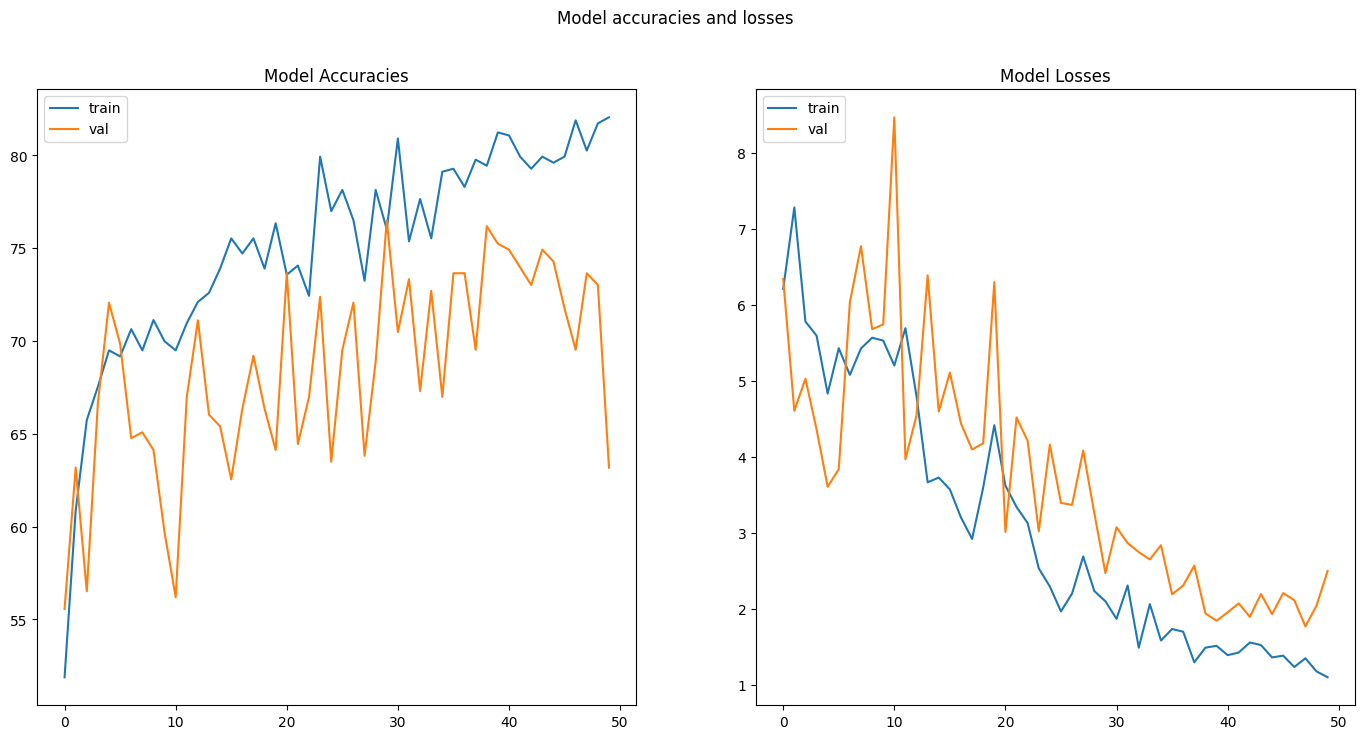

In [9]:
# Visualize the accuracies and losses over trainging for both validation and training

# TODO: napravi metodu za vizualizirati ovo? 

import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 8))
fig.suptitle("Model accuracies and losses")
ax1.plot(training.train_acc_history)
ax1.plot(training.val_acc_history)
ax1.set_title("Model Accuracies")
ax1.legend(['train', 'val'], loc='upper left')
ax2.plot(training.train_loss_history)
ax2.plot(training.val_loss_history)
ax2.set_title("Model Losses")
ax2.legend(['train', 'val'], loc='upper left')
plt.show()

In [15]:
# TODO: Loadaj model i usporedi test acc
import pprint


config = ConfigurationManager()
training_config = config.get_training_config()
training_test = Training(training_config)
# training_test.model = torch.load("artifacts/training/checkpoints/best.pt").to(torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))
# training_test.model = torch.load("models/best.pt").to(torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))
training_test.get_base_model()
PATH = "artifacts/training/checkpoints/checkpoint_epoch_29.pth"
checkpoint = training_test.load_checkpoint(PATH)
pprint.pprint(checkpoint)
training_test.get_dataloaders()
training_test.test()

[2024-05-22 19:33:43,247: INFO: common: YAML file: config/config.yaml loaded successfully!]
[2024-05-22 19:33:43,249: INFO: common: YAML file: params.yaml loaded successfully!]
[2024-05-22 19:33:43,250: INFO: common: Created directory at: artifacts]
[2024-05-22 19:33:43,254: INFO: common: Created directory at: artifacts/training]
[2024-05-22 19:33:43,255: INFO: common: Created directory at: artifacts/training/checkpoints]
(29,
 {'param_groups': [{'amsgrad': False,
                    'betas': (0.9, 0.999),
                    'capturable': False,
                    'differentiable': False,
                    'eps': 1e-08,
                    'foreach': None,
                    'fused': None,
                    'lr': 0.025,
                    'maximize': False,
                    'params': [0,
                               1,
                               2,
                               3,
                               4,
                               5,
                    

100%|██████████| 9/9 [00:00<00:00, 16.25it/s]

Test Accuracy: 77.77777777777777%


In [16]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

class_to_index = {'adenocarcinoma': 0, 'large.cell.carcinoma': 1, 'normal': 2, 'squamous.cell.carcinoma': 3}
index_to_class = {0: 'adenocarcinoma', 1: 'large.cell.carcinoma', 2: 'normal', 3: 'squamous.cell.carcinoma'}


# cm = confusion_matrix(y_real, y_pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
# disp.plot()
# plt.title("My confusion matrix")
# plt.show()

training.model.eval()
y_test = []
predictions = []

with torch.no_grad():
    for inputs, labels in tqdm(training.test_loader):
        inputs, labels = inputs.to(training.device), labels.to(training.device)
        outputs = training.model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        y_test.extend(labels.cpu().numpy().tolist())
        predictions.extend(predicted.cpu().numpy().tolist())

100%|██████████| 9/9 [00:00<00:00, 17.88it/s]


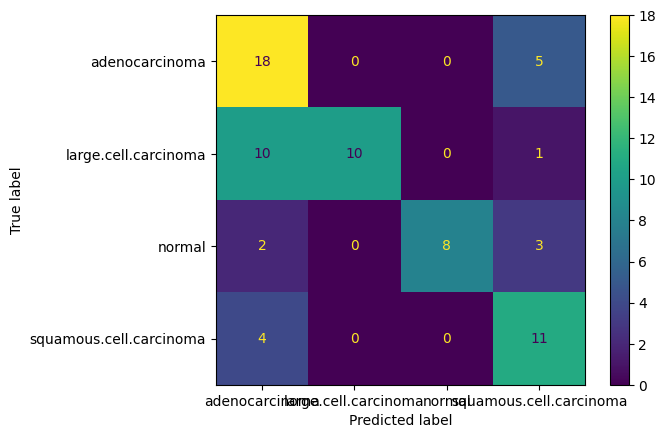

In [17]:
cm = confusion_matrix(y_test, predictions)
label_names = list({'adenocarcinoma': 0, 'large.cell.carcinoma': 1, 'normal': 2, 'squamous.cell.carcinoma': 3}.keys())
ConfusionMatrixDisplay(cm, display_labels=label_names).plot().figure_.savefig("models/aug_confusion_matrix.png")
plt.show()

In [19]:
cr_dict = classification_report(y_test, predictions, target_names=label_names, output_dict=True)
save_json(cr_dict, Path("models/aug_classification_report.json"))
print(classification_report(y_test, predictions, target_names=label_names, output_dict=False))

[2024-05-22 19:34:09,365: INFO: common: JSON file saved at models/aug_classification_report.json]
                         precision    recall  f1-score   support

         adenocarcinoma       0.53      0.78      0.63        23
   large.cell.carcinoma       1.00      0.48      0.65        21
                 normal       1.00      0.62      0.76        13
squamous.cell.carcinoma       0.55      0.73      0.63        15

               accuracy                           0.65        72
              macro avg       0.77      0.65      0.67        72
           weighted avg       0.76      0.65      0.66        72



In [21]:
acc_per_class = cm.diagonal()/cm.sum(axis=1).tolist()

acc_per_class_dict = {}
print("Accuracy per class:")
for i, class_ in enumerate(class_to_index):
    print(f"{class_}: {acc_per_class[i]}")
    acc_per_class_dict[class_] = acc_per_class[i]

save_json(acc_per_class_dict, Path("models/aug_acc_per_class.json"))

Accuracy per class:
adenocarcinoma: 0.782608695652174
large.cell.carcinoma: 0.47619047619047616
normal: 0.6153846153846154
squamous.cell.carcinoma: 0.7333333333333333
[2024-05-22 19:34:12,085: INFO: common: JSON file saved at models/aug_acc_per_class.json]
